Create the geopackage and import the necessary packages

In [1]:
from fudgeo.geopkg import GeoPackage
gpkg: GeoPackage = GeoPackage.create(r'C:\Users\Sysadmin\Desktop\QGIS\Python codes\C1.gpkg', flavor='EPSG')

from fudgeo.enumeration import GeometryType, SQLFieldType
from fudgeo.geopkg import FeatureClass, Field, SpatialReferenceSystem

import xarray as xr
import numpy as np

Load the given dataset and create the required fields of the feature classes(tables)

In [2]:
#Loading the dataset
data=xr.load_dataarray(r'C:\Users\Sysadmin\Desktop\QGIS\wreck_trajectories.nc')
srs_wkt = data.attrs['wkt']

srs = SpatialReferenceSystem(name='Custom', organization='EPSG', org_coord_sys_id=4326, definition=srs_wkt)

#fields and feature class of the child holding line data
fields = (Field('serial_no', SQLFieldType.integer),
          Field('start_time', SQLFieldType.datetime),
          Field('altitude', SQLFieldType.integer))
fc = gpkg.create_feature_class ('line_table_c', srs=srs, fields = fields, shape_type = GeometryType.linestring,spatial_index=False)

#fields and feature class of the parent holding polygon data
fields2 = (Field('mission_name', SQLFieldType.text),
          Field('date', SQLFieldType.date),
          Field('vehicle_name', SQLFieldType.text),
          Field('frequency', SQLFieldType.integer))
fc2 = gpkg.create_feature_class('mission_table_p', srs=srs, fields = fields2, shape_type = GeometryType.polygon,spatial_index=False)

Establishing parent child relationship between the two tables using SQL
parent - mission_table_p
child - line_table_c

In [3]:
from fudgeo.geopkg import GeoPackage

cursor = gpkg.connection.execute("""PRAGMA foreign_keys=off;""")
cursor = gpkg.connection.execute("""BEGIN TRANSACTION;""")
cursor = gpkg.connection.execute("""ALTER TABLE line_table_c RENAME TO old_line_table_c;""")
cursor = gpkg.connection.execute("""CREATE TABLE line_table_c
( fid INTEGER PRIMARY KEY AUTOINCREMENT,
  SHAPE object,
  parent_ID, INTEGER,
  serial_no object,
  start_time object,
  altitude object,
  CONSTRAINT p_to_c
    FOREIGN KEY (parent_ID)
    REFERENCES mission_table_p(fid)
);""")
cursor = gpkg.connection.execute("""COMMIT;""")
cursor = gpkg.connection.execute("""PRAGMA foreign_keys=on;""")

Input values into the parent and child tables

In [4]:
from fudgeo.geometry import LineStringM, Polygon
from shapely import LineString

#input values into the parent
rows2=[]
for i in range(len(data['leg'])):
    poly = data[i].transpose('index', 'xyz')
    shape = list(poly.shape)
    shape[-1] = 4
    arr2 = np.zeros(shape)
    arr2[:, 0] = poly[:, 1]
    arr2[:, 1] = poly[:, 0]
    arr2[:, 2] = poly[:, 2]

    x=arr2[:,:2].tolist() # taking the first two coordinates per point and turning it into a list
    line=LineString(x) # convert the list of points to a LineString
    bound=line.bounds # bounds gives the value(min x, min y, max x, max y)
    b=list(bound) # create a list of the bound coordinates
    margin=0.005 # degrees by which the polygon is extended
    y=[(b[0]-margin,b[1]-margin),(b[0]+margin,b[1]-margin),(b[0]+margin,b[1]+margin),(b[0]-margin,b[1]+margin)]
    
#poly=[[(0, 0), (1, 0), (1, 1),(0, 1)],[(2, 2), (4, 2), (4, 4), (2, 4)]]
#for i in poly:
    gpkg_wkb2 = Polygon(coordinates=[y],srs_id=fc2.spatial_reference_system.srs_id)
    
    rows2.append([gpkg_wkb2,'ZEUS','2023-11-14','OCEANIC','120'])

with gpkg.connection as conn:
    cursor = conn.execute("""INSERT INTO mission_table_p(SHAPE, mission_name, date, vehicle_name, frequency)
    VALUES(?,?,?,?,?)""", rows2[0])
    parent_ID = cursor.lastrowid #defining a different primary key so multiple primary keys from the child table can reference this key.
    
#input values into the child
rows=[]
for i in range(len(data['leg'])): # For i in rage of number of legs
    line = data[i].transpose('index', 'xyz')
    shape = list(line.shape) # Returns a list of shape values of the line
    shape[-1] = 3 # setting it to 3D
    arr = np.zeros(shape) # Returns a new array of given shape and type, filled with zeros
    arr[:, 0] = line[:, 1] # Swapping values to match intake
    arr[:, 1] = line[:, 0]
    
    gpkg_wkb = LineStringM(arr, srs_id=fc2.spatial_reference_system.srs_id)

    rows.append([gpkg_wkb, parent_ID, i,'2023-11-14 14:28:00','100'])

with gpkg.connection as conn:
    conn.executemany("""INSERT INTO line_table_c(SHAPE, parent_ID, serial_no, start_time, altitude) 
    VALUES(?,?,?,?,?)""",rows)


Type:        list
String form: [10, 3]
Length:      2
Docstring:  
Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified.

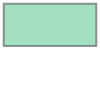

In [9]:
import shapely
y=shapely.geometry.box(bound[0],bound[1],bound[2],bound[3])
y

In [11]:
from fudgeo.geopkg import GeoPackage

cursor = gpkg.connection.execute("""SELECT * FROM line_table_c""")
features=cursor.fetchall()
features

[(1,
  b'GP\x00\x07\xe6\x10\x00\x00\x85\x08\x18l\xf1\x1d#@P4q:\x96\x1f#@:\xe7\x93j\xdf\x17F@M@\xab\xb8U\x18F@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\xd2\x07\x00\x00\n\x00\x00\x00P4q:\x96\x1f#@:\xe7\x93j\xdf\x17F@\x00\x00\x00\x00\x00\x00\x00\x00%\xcad\x84h\x1f#@\x15}00\xec\x17F@\x00\x00\x00\x00\x00\x00\x00\x00\x16h\xff\xba9\x1f#@\x97\x19j8\xf9\x17F@\x00\x00\x00\x00\x00\x00\x00\x00t:\xb2\xa7\n\x1f#@\xf6\x131`\x06\x18F@\x00\x00\x00\x00\x00\x00\x00\x00\xd3\x80H\xaf\xdb\x1e#@z\x9a\x81\x8e\x13\x18F@\x00\x00\x00\x00\x00\x00\x00\x00\xd9!8\xc4\xac\x1e#@IQX\xc8 \x18F@\x00\x00\x00\x00\x00\x00\x00\x00\x8b\xd6\xcc\x04~\x1e#@\x0c\xa9\xc0\xff-\x18F@\x00\x00\x00\x00\x00\x00\x00\x000\xb2\xc6#O\x1e#@d|x;;\x18F@\x00\x00\x00\x00\x00\x00\x00\x00E\xd0XC \x1e#@_(\xbbtH\x18F@\x00\x00\x00\x00\x00\x00\x00\x00\x85\x08\x18l\xf1\x1d#@M@\xab\xb8U\x18F@\x00\x00\x00\x00\x00\x00\x00\x00',
  1,
  None,
  0,
  '2023-11-14 14:28:00',
  100),
 (2,
  b'GP\x00\x07\xe6\x10\x00\x00\xabM\x89\xdf\xf